# Recognize MNIST Digit using Convolutional Network

https://www.kaggle.com/c/digit-recognizer

In [12]:
%matplotlib inline
import utils
reload(utils)
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Reshape
from keras.models import Model, Sequential
import numpy as np
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
import utils;reload(utils)
utils.disable_scrolling()

<IPython.core.display.Javascript object>

autoscrolling long output is disabled


((42000, 784), (28000, 784))


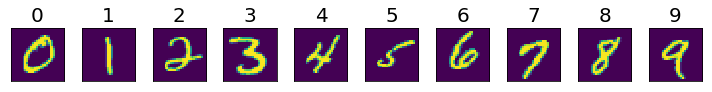

In [7]:
# regular MNIST dataset
data = utils.MNIST()
(X,Y) = data.get_ordered_sample()
utils.plot_array(X, titles=Y, cmap=None, limit=10)
mnist_train_batches = data.get_training_batches(batch_size=100)
mnist_test_batches = data.get_test_batches(batch_size=100)

# Competition data set
data = utils.MNIST_CSV()
X_train, Y_train = data.load_train()
competition_train_batches = utils.BatchIterator(X_train, utils.to_categorical(Y_train))
X_test = data.load_test()
print(X_train.shape, X_test.shape)

In [114]:
# 32 dimensions encoded
input_shape = (1, 28, 28)
model = Sequential(name='encoder')
model.add(Reshape(input_shape, input_shape=(784,)))
model.add(Conv2D(32, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
model.add(Conv2D(32, 3, 3, activation='relu', border_mode='same'))
model.add(Dropout(0.25))
#model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
model.add(Conv2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
model.add(Conv2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(Dropout(0.25))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()
#model.load_weights('models/convolutional_recognizer_2.weights.h5')
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
reshape_20 (Reshape)             (None, 1, 28, 28)     0           reshape_input_20[0][0]           
____________________________________________________________________________________________________
convolution2d_49 (Convolution2D) (None, 32, 28, 28)    320         reshape_20[0][0]                 
____________________________________________________________________________________________________
maxpooling2d_39 (MaxPooling2D)   (None, 32, 14, 14)    0           convolution2d_49[0][0]           
____________________________________________________________________________________________________
convolution2d_50 (Convolution2D) (None, 32, 14, 14)    9248        maxpooling2d_39[0][0]            
___________________________________________________________________________________________

In [115]:
# Train on the original MNIST data set
N = mnist_train_batches.N
N = 1000
model.fit_generator(mnist_train_batches, N, 10, verbose=2, validation_data=mnist_test_batches, nb_val_samples=min([100,N]));

Epoch 1/10
2s - loss: 0.3248 - acc: 0.9000 - val_loss: 0.3237 - val_acc: 0.9000
Epoch 2/10
2s - loss: 0.3222 - acc: 0.9000 - val_loss: 0.3199 - val_acc: 0.9000
Epoch 3/10
2s - loss: 0.3176 - acc: 0.9000 - val_loss: 0.3160 - val_acc: 0.9000
Epoch 4/10
2s - loss: 0.3058 - acc: 0.9000 - val_loss: 0.2846 - val_acc: 0.9000
Epoch 5/10
2s - loss: 0.2668 - acc: 0.9035 - val_loss: 0.2254 - val_acc: 0.9140
Epoch 6/10
2s - loss: 0.2165 - acc: 0.9190 - val_loss: 0.1742 - val_acc: 0.9320
Epoch 7/10
2s - loss: 0.1636 - acc: 0.9408 - val_loss: 0.1688 - val_acc: 0.9350
Epoch 8/10
2s - loss: 0.1566 - acc: 0.9408 - val_loss: 0.1169 - val_acc: 0.9540
Epoch 9/10
2s - loss: 0.1278 - acc: 0.9533 - val_loss: 0.0965 - val_acc: 0.9630
Epoch 10/10
2s - loss: 0.1206 - acc: 0.9562 - val_loss: 0.0873 - val_acc: 0.9750


In [116]:
# Test how we did
# Pretty accurate
N = 10000
loss, acc = model.test_on_batch(mnist_test_batches.x[:N], mnist_test_batches.y[:N])
print("Test Loss: %.5f, Accuracy: %.5f" % (loss, acc))

Test Loss: 0.08269, Accuracy: 0.97147


In [117]:
# Test current model with data for the competition
# Pretty accurate
N = 10000
loss, acc = model.test_on_batch(X_train[:N], utils.to_categorical(Y_train[:N]))
print("Test Loss: %.5f, Accuracy: %.5f" % (loss, acc))

Test Loss: 0.08516, Accuracy: 0.96993


In [118]:
# Train on Competition Data
model.fit_generator(competition_train_batches, competition_train_batches.N, 1, verbose=2,
                    validation_data=mnist_test_batches, nb_val_samples=100);

Epoch 1/1
85s - loss: 0.0336 - acc: 0.9884 - val_loss: 0.0419 - val_acc: 0.9870


(40, 10)


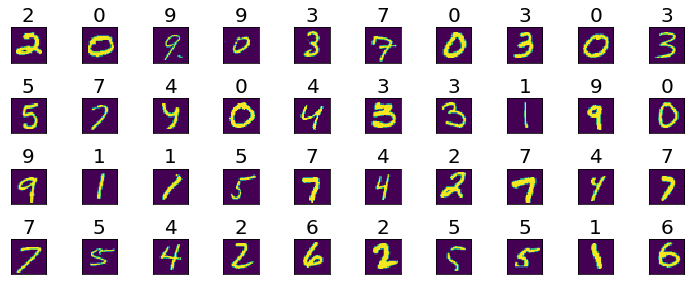

In [119]:
# Let's inspect some predictions
N=40
Y_test = model.predict(X_test[:N])
print(Y_test.shape)
Y_test_cat = np.argmax(Y_test, axis=1)
utils.plot_array(X_test, Y_test_cat, limit=N)

In [120]:
# Generate a new training set that has shifted samples.  Shift them all around
from scipy.ndimage.interpolation import shift
N = 10
X_reshaped = X_train.reshape(X_train.shape[0],28,28)
print(X_train.shape)
X2_train = np.concatenate([
    X_reshaped,
    shift(X_reshaped, (0,-4,4)), #TL
    shift(X_reshaped, (0,+4,+4)),#TR
    shift(X_reshaped, (0,-4,-4)),#BL
    shift(X_reshaped, (0,-4,+4)),#BR
    shift(X_reshaped, (0,0,-4)), #L
    shift(X_reshaped, (0,0,+4)), #R
    shift(X_reshaped, (0,+4,0)), #T
    shift(X_reshaped, (0,-4,0)), #B
])
Y2_train = np.concatenate([Y_train for i in range(0,9)])
X2_train = X2_train.reshape(X2_train.shape[0], 784)
print(X2_train.shape, Y2_train.shape)
batches = utils.BatchIterator(X2_train, utils.to_categorical(Y2_train), batch_size=1000)

(42000, 784)
((378000, 784), (378000,))


In [121]:
# Train using shifted samples
model.fit_generator(batches, batches.N, 1, verbose=2, validation_data=batches, nb_val_samples=1000);

Epoch 1/1
783s - loss: 0.0820 - acc: 0.9710 - val_loss: 0.0368 - val_acc: 0.9870


In [122]:
loss, acc = model.test_on_batch(mnist_test_batches.x, mnist_test_batches.y)
print("Test Loss: %.5f, Accuracy: %.5f" % (loss, acc))

Test Loss: 0.15905, Accuracy: 0.94086


In [167]:
# create submission for the competition
Y_test = recognizer.predict(X_test)
Y_test_cat = np.argmax(Y_test, axis=1)
with open("submission.csv", "w") as fp:
    fp.write("ImageId,Label\n")
    for i in range(0,len(Y_test_cat)):
        fp.write("%s,%s\n" % (i+1, Y_test_cat[i]))
    fp.close()

In [124]:
utils.save_model(model, "models/convolutional_recognizer_4")

Model saved: models/convolutional_recognizer_4.model.json
Weights saved: models/convolutional_recognizer_4.weights.h5
